In [ ]:
from google.colab import files
import zipfile
import os

# Upload the zip file
print("Upload your data.zip file:")
uploaded = files.upload()

# Get the uploaded filename
zip_filename = list(uploaded.keys())[0]

# Extract the zip file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('.')


Upload your data.zip file:


Saving m1-01.zip to m1-01.zip


In [ ]:
#Impoerting stuff
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2
import pandas as pd
import ntpath
import random

In [ ]:
datadir = 'm1-01'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

center  \
0  C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\center_2026_02_10_18_47_18_669.jpg   
1  C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\center_2026_02_10_18_47_18_772.jpg   
2  C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\center_2026_02_10_18_47_18_873.jpg   
3  C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\center_2026_02_10_18_47_18_975.jpg   
4  C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\center_2026_02_10_18_47_19_080.jpg   

                                                                                                            left  \
0   C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\left_2026_02_10_18_47_18_669.jpg   
1   C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\left_2026_02_10_18_47_18_772.jpg   
2   C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\left_2026_02_10_18_47_18_873.jpg   
3   C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\left_2026_02_10_18_47_18_975.jpg   
4   C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\left_2026_02_10_18_47_19_080.jpg   

                                                                                                            right  \
0   C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\right_2026_02_10_18_47_18_669.jpg   
1   C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\right_2026_02_10_18_47_18_772.jpg   
2   C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\right_2026_02_10_18_47_18_873.jpg   
3   C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\right_2026_02_10_18_47_18_975.jpg   
4   C:\Users\mohit\Desktop\Study\TnP\Self-driving\project\data-folder\m1-01\IMG\right_2026_02_10_18_47_19_080.jpg   

   steering  throttle  reverse     speed  
0       0.0       0.0      0.0  0.000081  
1       0.0       0.0      0.0  0.000078  
2       0.0       0.0      0.0  0.000079  
3       0.0       0.0      0.0  0.000079  
4       0.0       0.0      0.0  0.000078

In [ ]:
#Removes extra path details(head) and only returns file name(tail)
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
print(data.head())
print('total data:', len(data))
print(data.shape)

                               center                              left  \
0  center_2026_02_10_18_47_18_669.jpg  left_2026_02_10_18_47_18_669.jpg   
1  center_2026_02_10_18_47_18_772.jpg  left_2026_02_10_18_47_18_772.jpg   
2  center_2026_02_10_18_47_18_873.jpg  left_2026_02_10_18_47_18_873.jpg   
3  center_2026_02_10_18_47_18_975.jpg  left_2026_02_10_18_47_18_975.jpg   
4  center_2026_02_10_18_47_19_080.jpg  left_2026_02_10_18_47_19_080.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2026_02_10_18_47_18_669.jpg       0.0       0.0      0.0  0.000081  
1  right_2026_02_10_18_47_18_772.jpg       0.0       0.0      0.0  0.000078  
2  right_2026_02_10_18_47_18_873.jpg       0.0       0.0      0.0  0.000079  
3  right_2026_02_10_18_47_18_975.jpg       0.0       0.0      0.0  0.000079  
4  right_2026_02_10_18_47_19_080.jpg       0.0       0.0      0.0  0.000078  
total data: 2693
(2693, 7)


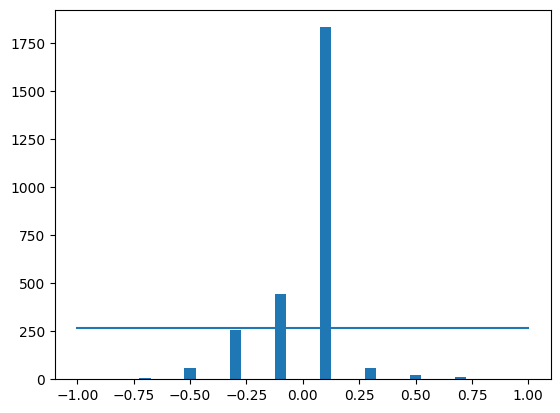

In [ ]:
#visualize the distribution of steering angles
num_bins = 10
samples_per_bin = 269
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

removed: 3500
remaining: 520


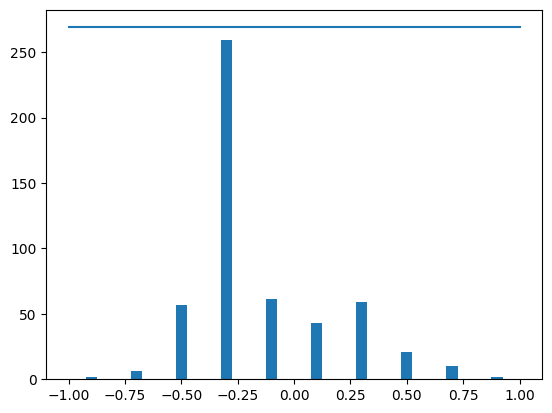

In [ ]:
#Removing any excess samples from bins-More Balanced-Improves training
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
#Prepares img with thir steering angles for training
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # steering angle from left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # steering angle from right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
print(len(image_paths))
print(len(steerings))

1560
1560


/tmp/ipython-input-2266687597.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
/tmp/ipython-input-2266687597.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
/tmp/ipython-input-2266687597.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3])+0.15)
/tmp/ipython-input-2266687597.py

Training Samples: 1248
Valid Samples: 312


Text(0.5, 1.0, 'Validation set')

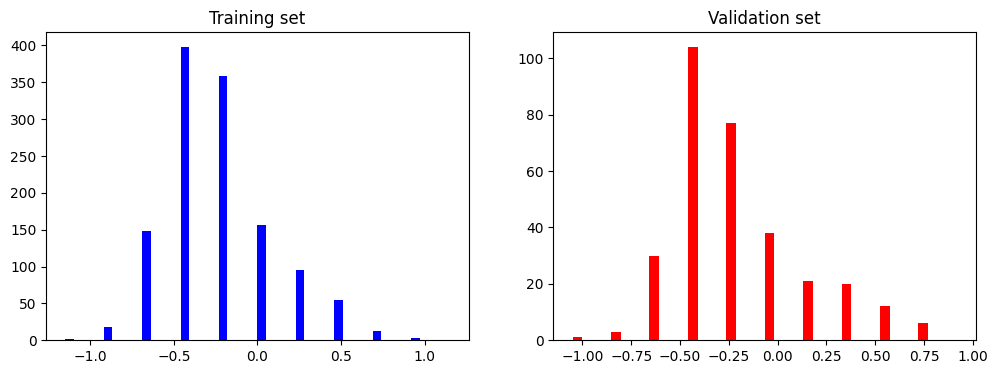

In [ ]:
#training + validation (like pre-testing)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

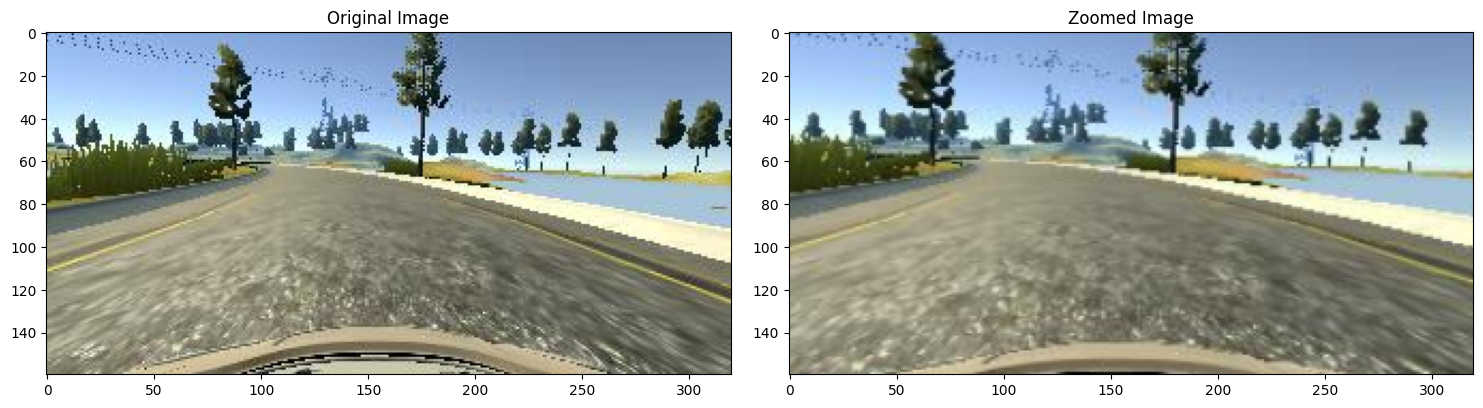

In [ ]:
def zoom(image):
    # Define zoom transformation (scale between 1.0 and 1.3)
    transform = A.Compose([A.Affine(scale=(1.0, 1.3), p=1.0)])

    # Apply transformation
    zoomed = transform(image=image)
    return zoomed['image']

# Load random image
image_path = image_paths[random.randint(0, 1000)]

# Read image using OpenCV (albumentations works with cv2)
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Apply zoom
zoomed_image = zoom(original_image)

# Display
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

plt.show()

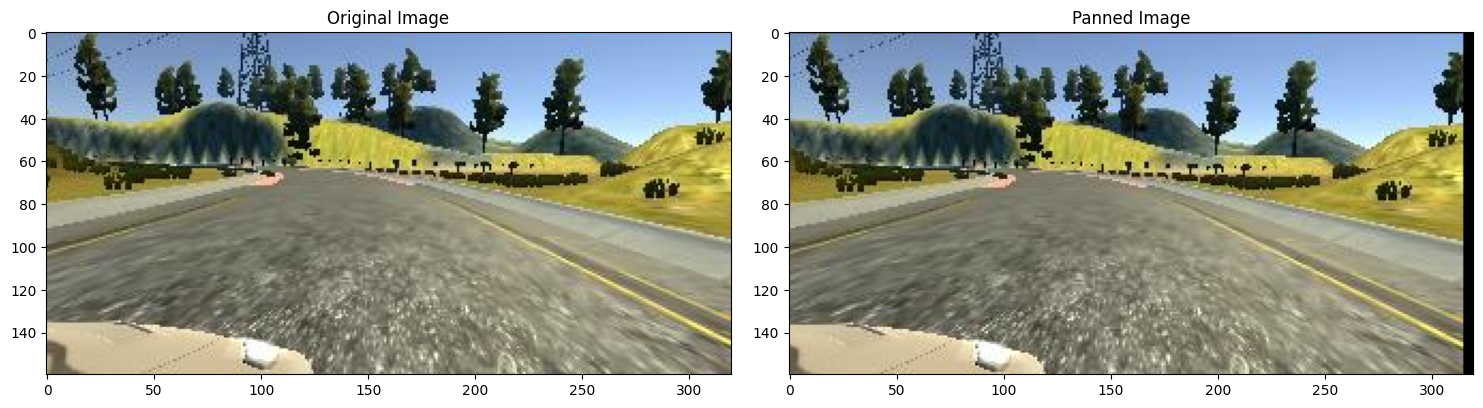

In [ ]:
def pan(image):
    pan = A.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, p=1.0)
    image = pan(image=image)['image']
    return image

image_path = image_paths[random.randint(0, 1000)]
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

plt.show()

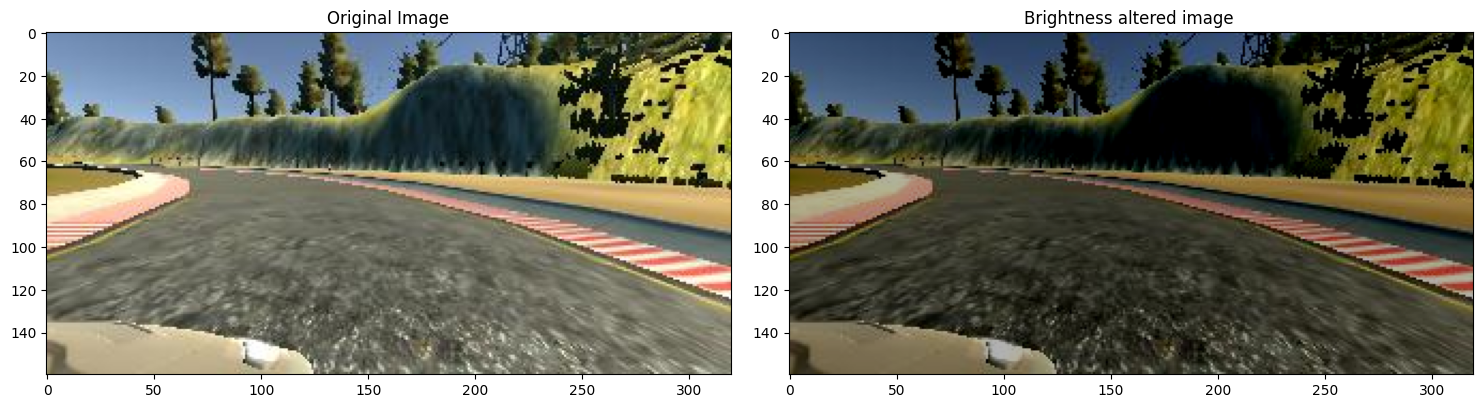

In [ ]:
def img_random_brightness(image):
    brightness = A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=1.0)
    image = brightness(image=image)['image']
    return image

image_path = image_paths[random.randint(0, 1000)]
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

plt.show()

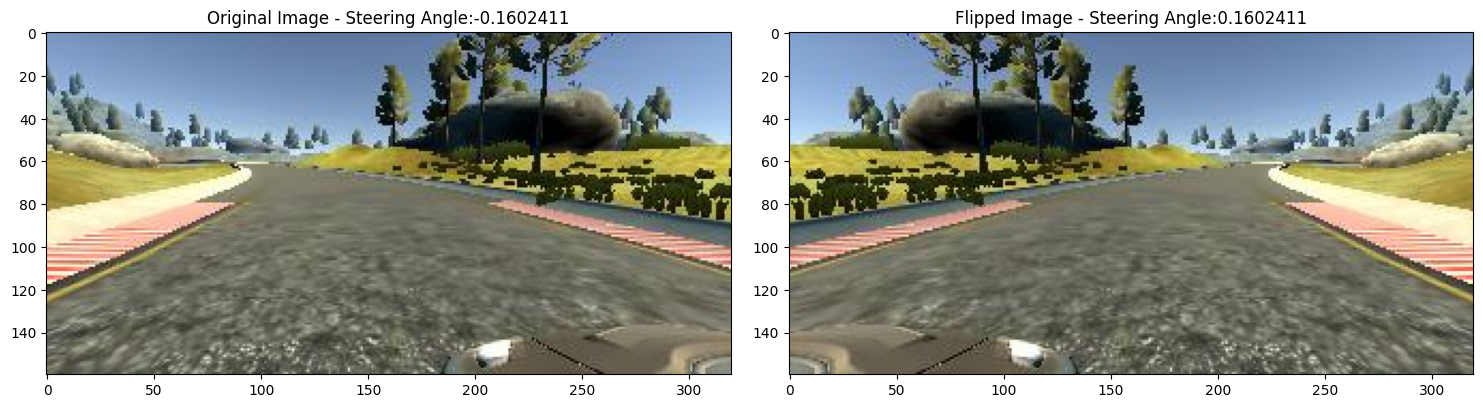

In [ ]:
def img_random_flip(image, steering_angle):
    flip = A.HorizontalFlip(p=1.0)
    image = flip(image=image)['image']
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image_path = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

plt.show()

In [ ]:
#Performed ZOOM, PAN, BRIGHTNESS-ALTERATION AND IMAGE-FLIP DATA
#TO PERFORM DATA AUGMENTATION
'''Technique used to artificially expand the size and diversity of a training
dataset by applying transformations to existing data. It helps improve machine
learning model performance by increasing data variety,reduces overfitting,
enhances generalization without requiring new data collection'''

'Technique used to artificially expand the size and diversity of a training\ndataset by applying transformations to existing data. It helps improve machine\nlearning model performance by increasing data variety,reduces overfitting,\nenhances generalization without requiring new data collection'

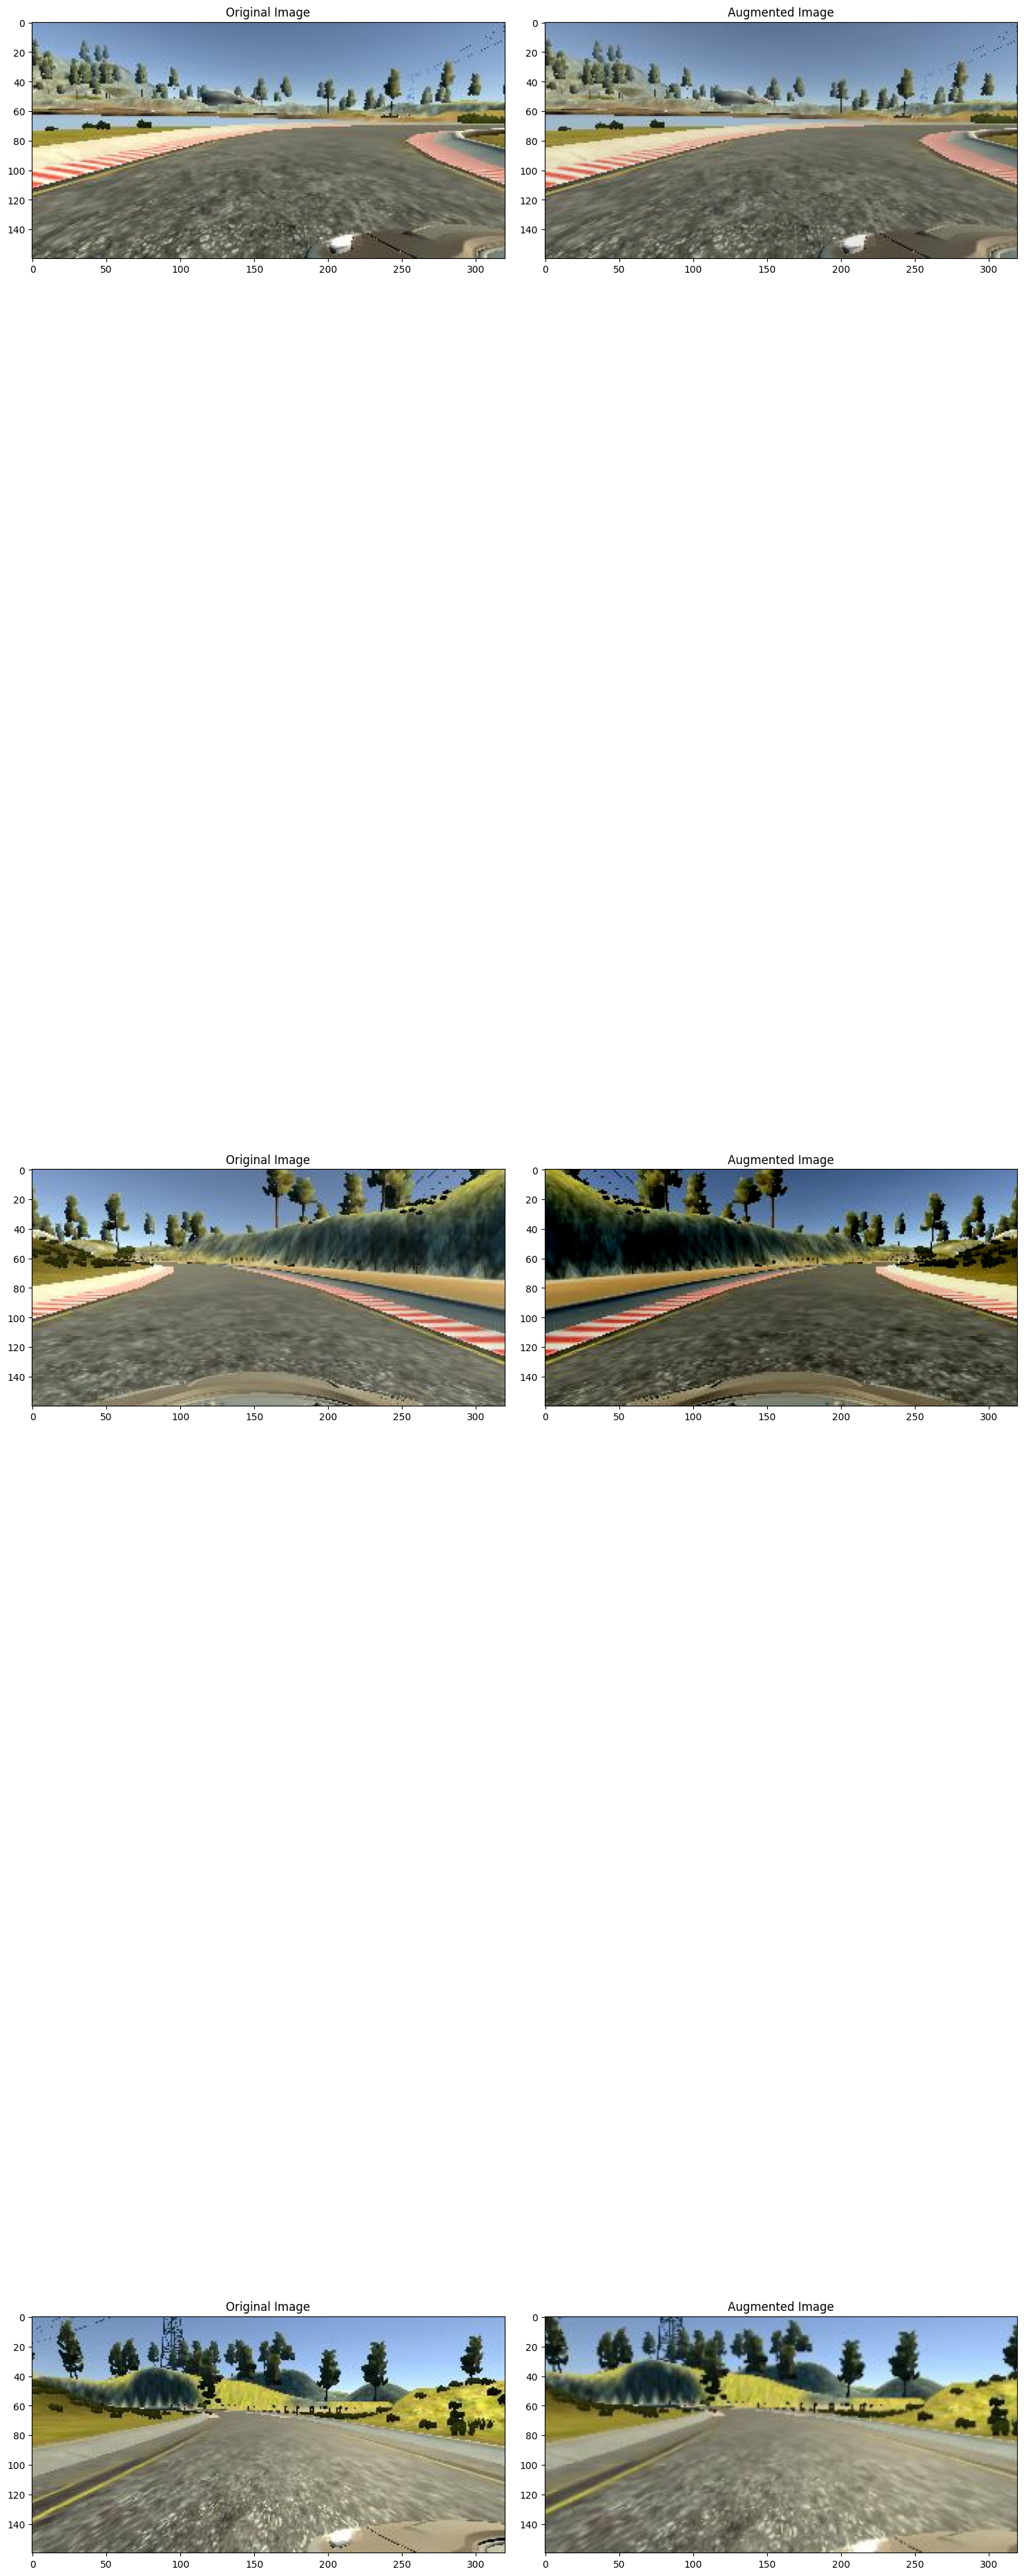

In [ ]:
#Data Augmentation
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle
#Visualoze few augmented data
ncol = 2
nrow = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(3):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Text(0.5, 1.0, 'Preprocessed Image')

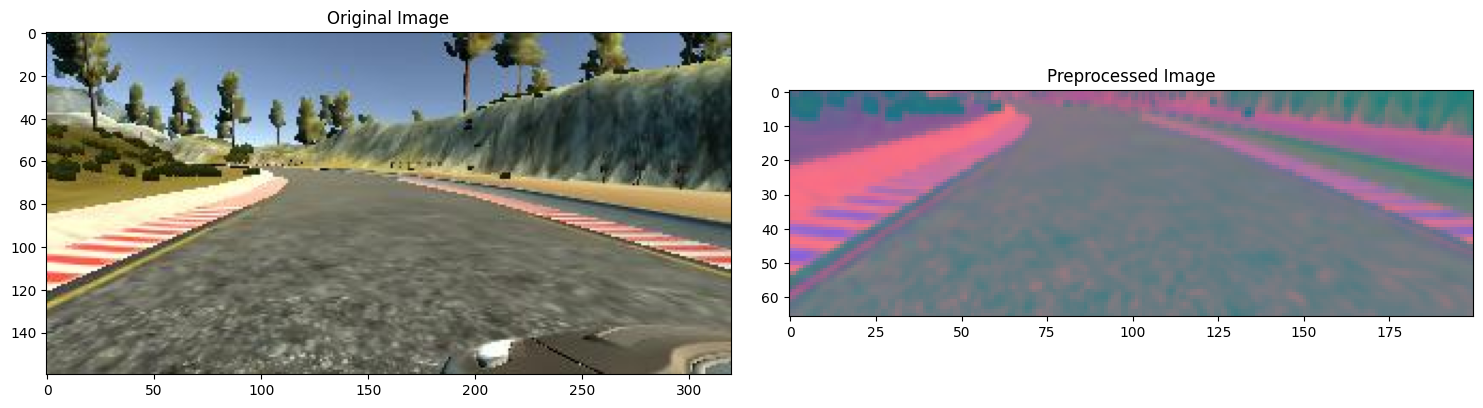

In [ ]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
!nvidia-smi

Tue Feb 10 16:32:19 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Text(0.5, 1.0, 'Validation Image')

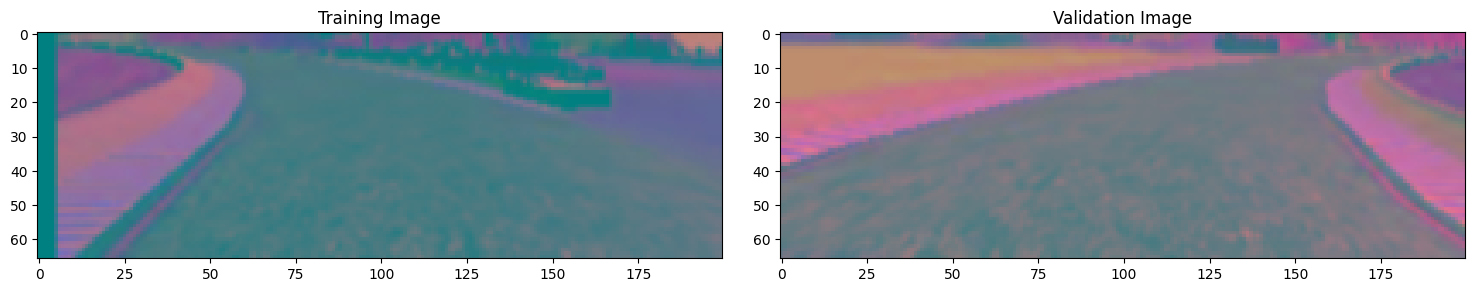

In [ ]:
# Making batches of augmented and pre-processed datasets to feed to NN
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))


x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

#Visualizing these training and valid batches
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [ ]:
#Making NN
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 18, 64)      │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,443 (1.01 MB)

 Trainable params: 264,443 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
Dodel = model.fit( batch_generator(X_train, y_train, 100, 1), steps_per_epoch=200, epochs=20,
    validation_data=batch_generator(X_valid, y_valid, 100, 0), validation_steps=16, verbose=1, shuffle=1 )

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 287ms/step - loss: 0.1806 - val_loss: 0.0407
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - loss: 0.0578 - val_loss: 0.0335
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 55s 278ms/step - loss: 0.0449 - val_loss: 0.0363
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 59s 297ms/step - loss: 0.0409 - val_loss: 0.0363
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 266ms/step - loss: 0.0375 - val_loss: 0.0327
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 55s 274ms/step - loss: 0.0382 - val_loss: 0.0338
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 262ms/step - loss: 0.0339 - val_loss: 0.0307
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - loss: 0.0345 - val_loss: 0.0301
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 55s 278ms/step - loss: 0.0331 - val_loss: 0.0275
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 273ms/step - loss: 0.0344 - val_loss: 0.0316
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - loss: 0.0330 - val_loss: 0.0295
Epoch 12/20
200/200

Text(0.5, 0, 'Epoch')

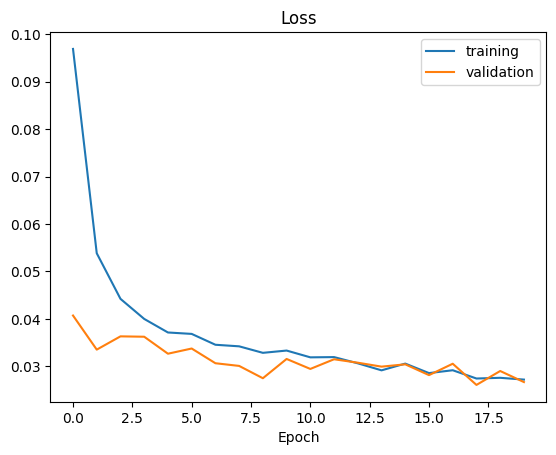

In [ ]:
plt.plot(Dodel.history['loss'])
plt.plot(Dodel.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('m1-01.h5')
from google.colab import files
files.download('m1-01.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>